In [1]:
# -- imports
%matplotlib inline
import numpy as np
import os
import pandas as pd
from config import *
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

In [2]:
#Create path for diff, srch, temp images
pttype = '*'
flist = []
# for i in range(1):
#     path = os.path.join(configs["dpath"],'stamps%d'%i,'SNWG','Archive','*','Y1','*','*',pttype + '*.fits')
#     flist.append(sorted(glob.glob(path)))
hu = ['stamps1','20130829', '20130831', '20130901']
for i in hu[1:]:
    path = os.path.join(configs["dpath"],hu[0],'SNWG','Archive','*','Y1',i,'*',pttype + '*.fits')
    flist.append(sorted(glob.glob(path)))
# hu2 = ['stamps2','20130829','20130831','20130901']
# for k in hu2[1:]:
#     path = os.path.join(configs["dpath"],hu2[0],'SNWG','Archive','*','Y1',k,'*',pttype + '*.fits')
#     flist.append(sorted(glob.glob(path)))
# hu = np.concatenate((hu1,hu2))
flist = np.concatenate((flist))


In [3]:
len(flist)

8061

In [4]:
#Extract the ID of the flist
ID =[int(f.split('/')[-1][4:-5]) for f in flist]
ID [:9]

[6962491,
 6962491,
 6962491,
 6963820,
 6963820,
 6963820,
 6969123,
 6969133,
 6969123]

In [5]:
#extract from .feather file the ID that are on flist
ffpath = os.path.join(configs["dpath"], "autoscan_features.3.feather") #this .feather file contain only the ID and OBJECT_TYPE for the images that I have on 
new_labels = pd.read_feather(ffpath)
current_labels = new_labels[new_labels["ID"].isin(ID)]
current_labels = current_labels[["ID", "OBJECT_TYPE"]]
current_labels.drop_duplicates(inplace=True) 
current_labels = current_labels.sort_values(by= ["ID"]).reset_index(drop=True)
counts_type = np.unique(current_labels['OBJECT_TYPE'], return_counts=True)
#how_many = {"Real (0)":counts_type[1][0], "Bogus (1)": counts_type[1][1] }

if len(counts_type[0]) == 2:
    print("Real (0) = {} and Bogus (1) = {}".format(counts_type[1][0], counts_type[1][1]))
if len(counts_type[0]) == 1:
    if counts_type[0] == 0:
        print("Real (0) = {}".format(counts_type[0][0]))
    else:
        print("Bogus (1) = {}".format(counts_type[0][0]))

Real (0) = 790 and Bogus (1) = 1897


In [6]:
imlist_dict = {}

# stores the name of the images as a list for ID above
#is a circle because i extract the ID for the flist, buttt
imlist_dict['flist'] = [f for f in flist if int(f.split('/')[-1][4:-5]) in current_labels['ID'].to_numpy()]
#print (len(imlist_dict['flist']))
#print(flist.nbytes)
#del(flist)
imlist_dict["imshp"] = fits.open((imlist_dict["flist"][0]))[0].data.shape #shape row,col
extension="fits"
imdtype = {"fits":float, "gif":np.uint8, }

#sort as: descending ID and diff, srch, temp
imlist_dict["flist"] = sorted(imlist_dict["flist"], key=lambda s: s.split('/')[-1][:4])
imlist_dict["flist"]= sorted(imlist_dict["flist"], key=lambda s: int(s.split('/')[-1][4:-5]))

#container for data train and data test
data_full = np.zeros((len(imlist_dict["flist"]),imlist_dict["imshp"][0], imlist_dict["imshp"][1]),imdtype[extension])

#fill the container and open images
for i in range(len(imlist_dict["flist"])):
    datas = fits.open(''.join(imlist_dict["flist"][i]), memmap=True)
    #datas.close()
    data_full[i] = datas[0].data
    #print("{}, path:{}".format(i,imlist_dict["flist"][i]))
    datas.close()

In [7]:
#sort as: descending ID and diff, srch, temp
imlist_dict["flist"] = sorted(imlist_dict["flist"], key=lambda s: s.split('/')[-1][:4])
imlist_dict["flist"]= sorted(imlist_dict["flist"], key=lambda s: int(s.split('/')[-1][4:-5]))

In [8]:
imlist_dict["flist"][:10]

['/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681007/diff6960252.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681007/srch6960252.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681007/temp6960252.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681006/diff6961062.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681006/srch6961062.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681006/temp6961062.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681006/diff6961064.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681006/srch6961064.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829/470681006/temp6961064.fits',
 '/global/cscratch1/sd/taceroc/data/stamps1/SNWG/Archive/2013/Y1/20130829

In [9]:
current_labels

,ID,OBJECT_TYPE
0,6960252,1
1,6961062,1
2,6961064,1
3,6961300,1
4,6961308,0
...,...,...
2682,7778614,0
2683,7778883,1
2684,7779002,1
2685,7779022,1


In [10]:
imlist_dict["imshp"][0]

51

In [11]:
data_full.shape

(8061, 51, 51)

In [12]:
# --normalize
# mean and std for diff images
# min and max for srch and temp

data_norm = data_full.astype(float)
data_full = None
# --normalize
# mean and std for diff images
# min and max for srch and temp

data_norm[::3] = (data_norm[::3]- data_norm[::3].mean(axis=(1,2), keepdims=True))/data_norm[::3].std(axis=(1,2), keepdims=True) #diff
data_norm[1::3]= (data_norm[1::3]-data_norm[1::3].min(axis=(1,2), keepdims=True))/data_norm[1::3].max(axis=(1,2), keepdims=True) #srch
data_norm[2::3]= (data_norm[2::3]-data_norm[2::3].min(axis=(1,2), keepdims=True))/data_norm[2::3].max(axis=(1,2), keepdims=True) #temp
#print(data_full.nbytes)
#del(data_full)
#print(data_full.nbytes)


In [13]:
#concatenate diff srch temp for the same ID

#final_data = np.zeros((int(len(data_full)//3),imlist_dict["imshp"][0], imlist_dict["imshp"][1]*3))
final_data = np.concatenate((data_norm[::3],data_norm[1::3],data_norm[2::3]), axis = 2)


In [14]:
print('Final lenght of data = {}'.format(final_data.shape)) 

Final lenght of data = (2687, 51, 153)


In [15]:
#exxtract the objects  = 0
df_ID_0 = current_labels[current_labels["OBJECT_TYPE"]==0]
#df_ID_0

In [16]:
#exxtract the objects  = 1
df_ID_1 = current_labels[current_labels["OBJECT_TYPE"]==1]
#df_ID_1

In [17]:
#the len is the minimun of object 0, and object 1. To have equal data of both
len_each_set = min(len(df_ID_0), len(df_ID_1))
len_each_set

790

In [18]:
len(df_ID_0), len(df_ID_1)

(790, 1897)

In [19]:
if len(df_ID_0) <= len_each_set:
    #extract random the number of data classify as 0
    index_data_ID0 = df_ID_0.sample(len_each_set-10, random_state = 2).sort_index()
    #extract random the number of data classify as 1
    index_data_ID1 = df_ID_1.sample(len_each_set+10,random_state = 2).sort_index()
else:
    #extract random the number of data classify as 0
    index_data_ID0 = df_ID_0.sample(len_each_set+10, random_state = 2).sort_index()
    #extract random the number of data classify as 1
    index_data_ID1 = df_ID_1.sample(len_each_set-10,random_state = 2).sort_index()

In [20]:
index_data_ID0

,ID,OBJECT_TYPE
4,6961308,0
7,6961351,0
9,6961845,0
13,6961954,0
14,6961958,0
...,...,...
2670,7778057,0
2672,7778110,0
2678,7778234,0
2682,7778614,0


In [21]:
len(index_data_ID1),len(index_data_ID0)

(800, 780)

In [22]:
#convert index to numpy to iterate
index_ID0 = index_data_ID0.index.to_numpy()
index_ID0[:9]

array([ 4,  7,  9, 13, 14, 15, 16, 17, 24])

In [23]:
#convert index to numpy to iterate
index_ID1 = index_data_ID1.index.to_numpy()
index_ID1[:9]

array([ 2,  3,  5, 10, 22, 23, 26, 28, 31])

In [24]:
#concatenate both index
indexes = sorted(np.concatenate((index_ID0, index_ID1)))
indexes[:10]

[2, 3, 4, 5, 7, 9, 10, 13, 14, 15]

In [25]:
#extract the data from the index given above, of the complete data, where 0 and 1 are not equal
equal_type_data = len(indexes)
print("Len of data where len(ID_0) = len(ID_1) = {}".format(equal_type_data))

Len of data where len(ID_0) = len(ID_1) = 1580


In [26]:
#70% is for training
#30% testing
train_len = int(equal_type_data*0.70)
test_len = equal_type_data  - int(equal_type_data*0.70)
print('Final lenght of train = {}, Final lenght of test = {} '.format(train_len, test_len))

Final lenght of train = 1106, Final lenght of test = 474 


In [27]:
import random
random.seed(4)
random_index = random.sample(range(0, equal_type_data), train_len)
random_index[:10]

[483, 621, 211, 1477, 811, 980, 317, 184, 136, 40]

In [28]:
#70% is for training
#30% testing
train = np.array([final_data[i] for i in [indexes[i] for i in sorted(random_index)]])
test = np.array([final_data[i] for i in indexes if i not in [indexes[i] for i in sorted(random_index)]])
len(train),len(test)

(1106, 474)

In [29]:
#extracting the label 0 or 1
targets = [current_labels.iloc[i]["OBJECT_TYPE"] for i in indexes]
targets[:10]

[1, 1, 0, 1, 0, 0, 1, 0, 0, 0]

In [30]:
IDss = [current_labels.iloc[i]["ID"] for i in indexes]
IDss[:10]

[6961064,
 6961300,
 6961308,
 6961332,
 6961351,
 6961845,
 6961933,
 6961954,
 6961958,
 6962011]

In [31]:
current_labels[current_labels['ID'] == 6962193]

,ID,OBJECT_TYPE


In [32]:
#split the targets
train_targ = np.array([current_labels.iloc[i]["OBJECT_TYPE"] for i in [indexes[i] for i in sorted(random_index)]])
test_targ = np.array([current_labels.iloc[i]["OBJECT_TYPE"] for i in indexes if i not in [indexes[i] for i in sorted(random_index)]])
len(train_targ),len(test_targ)

(1106, 474)

In [33]:
# np.save('train_targ_7.npy', train_targ)
# np.save('test_targ_7.npy', test_targ)

In [34]:
(unique, counts) = np.unique(test_targ, return_counts=True)
(unique, counts)

(array([0, 1]), array([225, 249]))

In [35]:
(unique, counts) = np.unique(train_targ, return_counts=True)
(unique, counts)

(array([0, 1]), array([555, 551]))

In [36]:
#extract the ID0
ID0 = index_data_ID0["ID"].to_numpy()
ID0[:9]

array([6961308, 6961351, 6961845, 6961954, 6961958, 6962011, 6962027,
       6962037, 6962376])

In [37]:
#extract the ID1
ID1 = index_data_ID1["ID"].to_numpy()
ID1[:9]

array([6961064, 6961300, 6961332, 6961933, 6962158, 6962225, 6962414,
       6962438, 6962536])

In [38]:
#concatenate the ID that are going to be used here
IDs = sorted(np.concatenate((ID0, ID1)))
IDs[:10]

[6961064,
 6961300,
 6961308,
 6961332,
 6961351,
 6961845,
 6961933,
 6961954,
 6961958,
 6962011]

In [39]:
len(IDs)

1580

In [40]:
#split the targets
train_ID = np.array([current_labels.iloc[i]["ID"] for i in [indexes[i] for i in sorted(random_index)]])
test_ID = np.array([current_labels.iloc[i]["ID"] for i in indexes if i not in [indexes[i] for i in sorted(random_index)]])
len(train_ID),len(test_ID)

(1106, 474)

In [41]:
train_ID[0]

6961064

In [42]:
flist[1].split('/')[-1][4:-5]

'6962491'

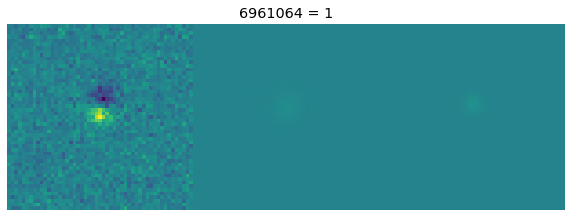

In [43]:
plt.style.use("bmh")

plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots()
plt.axis("off")
plt.imshow(train[0])
plt.title("{} = {}".format(train_ID[0], train_targ[0]))
plt.show()


In [46]:
final_data=None
flist=None
current_labels=None
imlist_dict=None

In [47]:
np.random.seed(1)
tf.random.set_seed(346)

# -- define the network
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="valid", activation="relu", input_shape=(51, 153, 1))
layer2 = keras.layers.MaxPooling2D((2, 2), strides=2)
layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="valid", activation="relu", input_shape=(51, 153, 1))
layer4 = keras.layers.MaxPooling2D((2, 2), strides=2)

layer5 = keras.layers.Flatten()
#layer6 = keras.layers.Dropout(0.4)

layer7 = keras.layers.Dense(32, activation="relu")
layer8 = keras.layers.Dense(2, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer7,layer8]

# -- instantiate the convolutional neural network
model = keras.Sequential(layers)

opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- feautres need to have an extra axis on the end (for mini-batching)
feat_tr2 = train.reshape(len(train), 51, 153, 1)
feat_te2 = test.reshape(len(test), 51, 153, 1)

# -- fit the model
history = model.fit(feat_tr2, train_targ, validation_split=0.20, epochs=40, batch_size=20)

# -- print the accuracy
loss_tr, acc_tr = model.evaluate(feat_tr2, train_targ)
loss_te, acc_te = model.evaluate(feat_te2, test_targ)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))



# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")




InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

In [ ]:
# file1 = open("../outputs/consecutive/results.txt","a")
# file1.write('Final lenght of train = {}, Final lenght of test = {} \n'.format(train_len, test_len))
# file1.write('unique test: {} \n'.format(np.unique(test_targ, return_counts=True)))
# file1.write('unique train: {} \n'.format(np.unique(train_targ, return_counts=True)))
# file1.write("Training accuracy for %s"%hu+": {0:.4f} \n".format(acc_tr))
# file1.write("Testing accuracy for %s"%hu+": {0:.4f} \n".format(acc_te))
# file1.close()

In [ ]:
#keys of the model
history.history.keys()

In [ ]:
loss_te

In [ ]:
# -- plot the loss function
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "test"], loc="upper left")
ax.set_xlabel("epoch", fontsize=15)
ax.set_ylabel("loss", fontsize=15)
#plt.savefig("loss.pdf",bbox_inches="tight")
#fig.show()

In [ ]:
# -- plot the accuracy function
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train", "test"], loc="upper left")
ax.set_xlabel("epoch", fontsize=15)
ax.set_ylabel("acc", fontsize=15)
#plt.savefig("acc.pdf",bbox_inches="tight")
#fig.show()

In [ ]:
#confusion matrix for test data
y_pred = model.predict(feat_te2)
con_mat = tf.math.confusion_matrix(labels=test_targ, predictions=np.argmax(y_pred,axis=1)).numpy()
con_mat

In [ ]:
con_mat.flatten()

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1], 
                     columns = [0,1])
con_mat_df
#How do I know what is the order: 0,1 or 1,0??

In [ ]:
con_mat_norm.flatten()

In [ ]:
labels = [f"{v1}\n{v2*100}%" for v1, v2 in
          zip(con_mat.flatten(),con_mat_norm.flatten())]
#labels = np.asarray(labels).reshape(2,2)
labels = np.asarray(labels).reshape(2,2)

In [ ]:
categories = ["0: Real", "1: Bogus"]

In [ ]:

figure = plt.figure(figsize=(4, 5))
sns.heatmap(con_mat, annot=labels,cbar=False,fmt='',xticklabels=categories,yticklabels=categories,cmap='Pastel2_r')#plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusionmatrix_small_GPUGPUTAC_7030.pdf",bbox_inches="tight")
plt.show()

In [ ]:
imlist_dict["flist"][999:1002]

In [ ]:
plt.style.use("bmh")

plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots()
plt.axis("off")
plt.imshow(train[333])
plt.title(train_ID[333])

In [ ]:
plt.style.use("bmh")

plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots()
plt.axis("off")
plt.imshow(train[1400][:,:])
plt.title(train_ID[1400])

In [49]:
import matplotlib
matplotlib.__version__

'3.3.4'

In [50]:
tf.__version__

'2.0.0'